In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Epoch [10/100], Loss: 0.0378
Epoch [20/100], Loss: 0.0164
Epoch [30/100], Loss: 0.0094
Epoch [40/100], Loss: 0.0072
Early stopping
Mean Absolute Error (MAE) on training data: 30.69
Predicted number of passengers for next month: 416.96


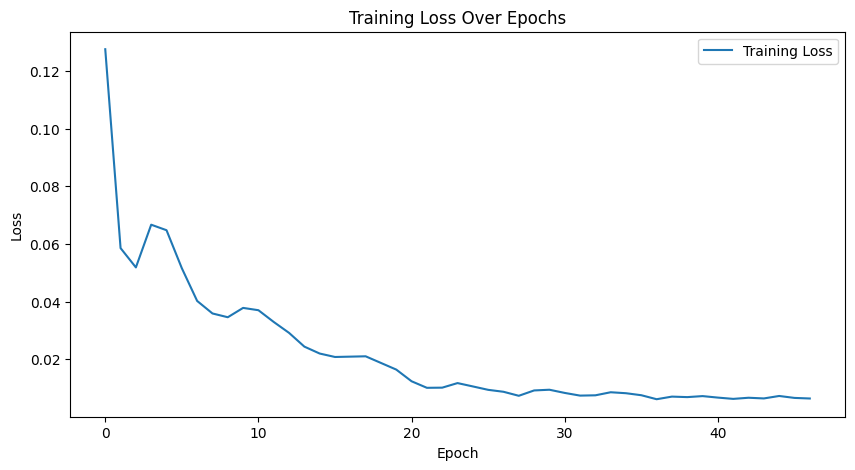

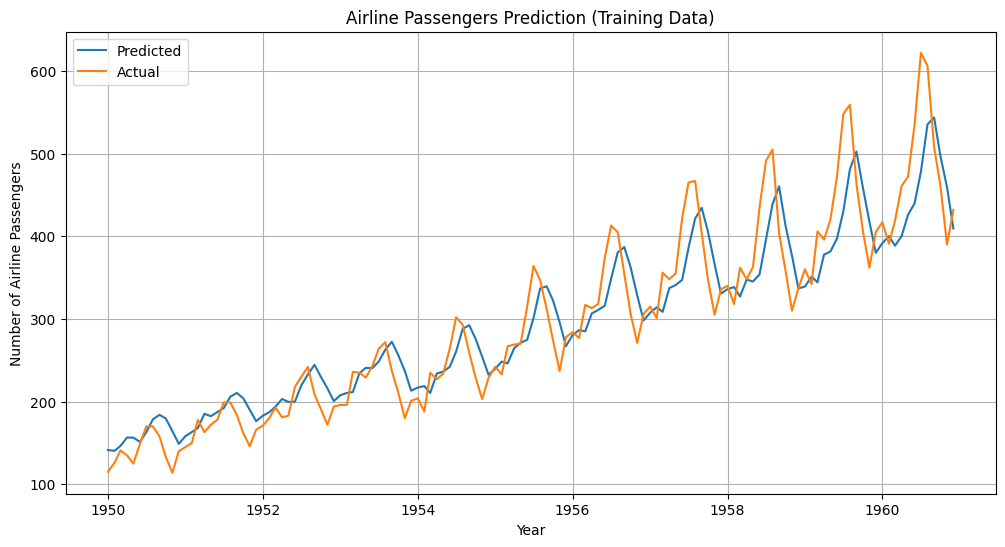

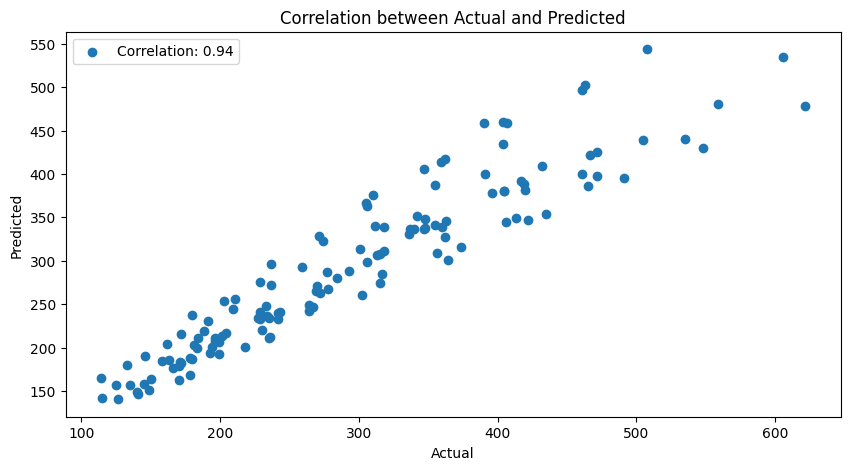

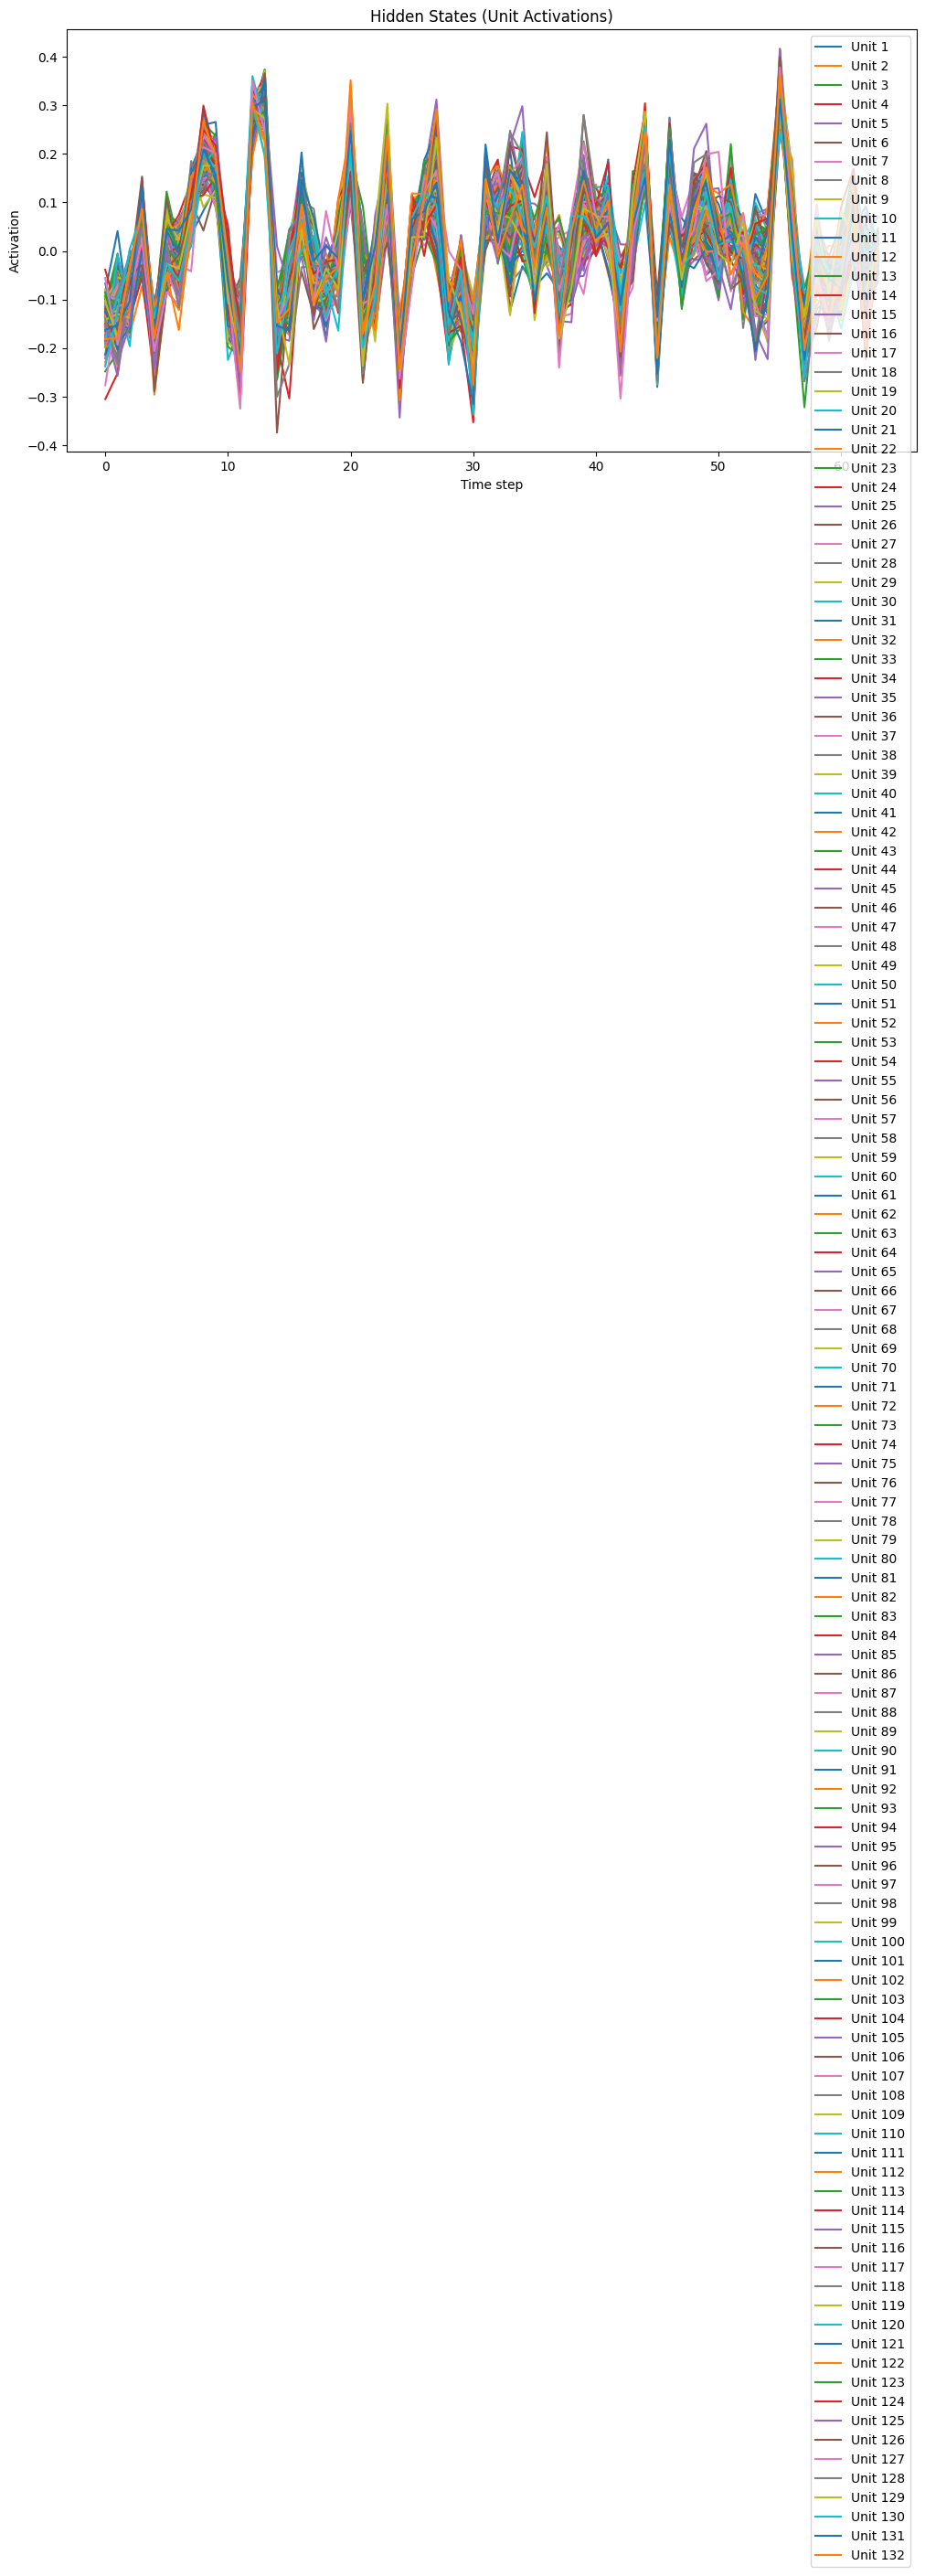

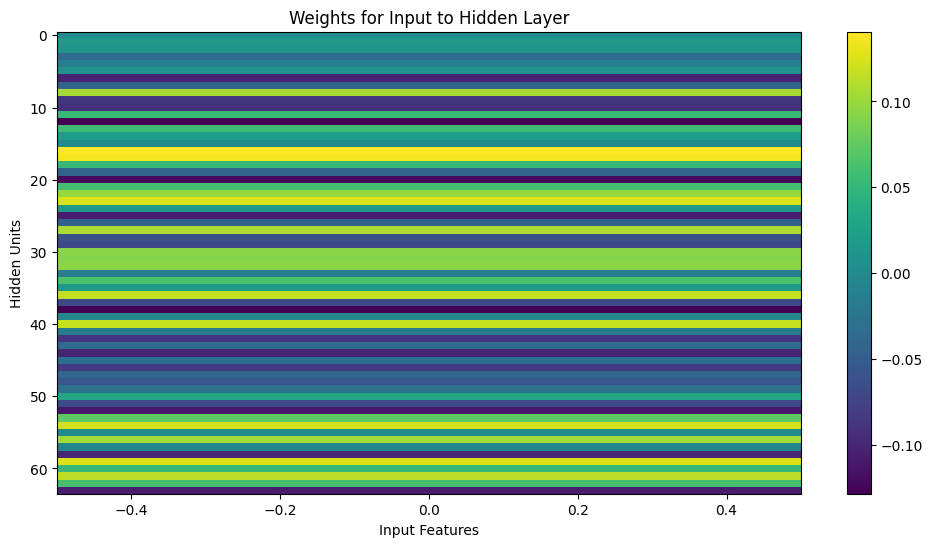

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

# Step 1: Load and Preprocess Data

# Load the Air Passengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

# Convert to PyTorch tensor
data = torch.tensor(scaled_data, dtype=torch.float32)

# Create sequences of data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

seq_length = 12  # sequence length (number of time steps to look back)
x_train, y_train = create_sequences(data, seq_length)

# Step 2: Define an RNN Model
class ComplexRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, bidirectional=False, dropout=0.0):
        super(ComplexRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size)
        
        out, hidden_states = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out, hidden_states

# Step 3: Training and Evaluation

# Hyperparameters
input_size = 1  # number of features (in this case, it's just the number of passengers)
hidden_size = 64
output_size = 1
num_layers = 2
bidirectional = True
dropout = 0.2
learning_rate = 0.001
num_epochs = 100
l2_lambda = 0.001  # L2 regularization parameter
patience = 10  # Early stopping patience

# Initialize the model, loss function, and optimizer
model = ComplexRNN(input_size, hidden_size, output_size, num_layers, bidirectional=bidirectional, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

# Early stopping variables
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

losses = []
for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping")
        break

    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs, hidden_states = model(x_train)
    loss = criterion(outputs, y_train)
    losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Early stopping logic
    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate Mean Absolute Error (MAE) after training
model.eval()
with torch.no_grad():
    predicted, _ = model(x_train)
    predicted = scaler.inverse_transform(predicted.numpy().reshape(-1, 1))
    y_train_orig = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))
    mae = mean_absolute_error(y_train_orig, predicted)
    print(f'Mean Absolute Error (MAE) on training data: {mae:.2f}')

# Step 4: Test on New Data

# Generate new data for testing (out-of-sample)
new_data = scaled_data[-seq_length:]  # take the last sequence as new data
x_test = torch.tensor(new_data.reshape(1, seq_length, -1), dtype=torch.float32)

# Make predictions on the new data
model.eval()
with torch.no_grad():
    predicted_new, _ = model(x_test)
    predicted_new = scaler.inverse_transform(predicted_new.numpy().reshape(-1, 1))
    print(f'Predicted number of passengers for next month: {predicted_new[0][0]:.2f}')

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[seq_length:], predicted, label='Predicted')
plt.plot(df.index[seq_length:], y_train_orig, label='Actual')
plt.xlabel('Year')
plt.ylabel('Number of Airline Passengers')
plt.title('Airline Passengers Prediction (Training Data)')
plt.legend()
plt.grid(True)
plt.show()

# Plot correlation
correlation, _ = pearsonr(y_train_orig.flatten(), predicted.flatten())
plt.figure(figsize=(10, 5))
plt.scatter(y_train_orig, predicted, label=f'Correlation: {correlation:.2f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Correlation between Actual and Predicted')
plt.legend()
plt.show()

# Plot hidden states (unit activations)
hidden_states = hidden_states[-1].squeeze().detach().numpy()
plt.figure(figsize=(12, 6))
for i in range(hidden_states.shape[0]):
    plt.plot(hidden_states[i], label=f'Unit {i+1}')
plt.xlabel('Time step')
plt.ylabel('Activation')
plt.title('Hidden States (Unit Activations)')
plt.legend()
plt.show()

# Plot weights for input -> hidden layers
weights_input_hidden = model.rnn.weight_ih_l0.detach().numpy()
plt.figure(figsize=(12, 6))
plt.imshow(weights_input_hidden, aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('Input Features')
plt.ylabel('Hidden Units')
plt.title('Weights for Input to Hidden Layer')
plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'complex_rnn_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch [10/100], Loss: 0.0655
Epoch [20/100], Loss: 0.0082
Epoch [30/100], Loss: 0.0036
Epoch [40/100], Loss: 0.0041
Epoch [50/100], Loss: 0.0024
Epoch [60/100], Loss: 0.0016
Epoch [70/100], Loss: 0.0014
Epoch [80/100], Loss: 0.0012
Epoch [90/100], Loss: 0.0011
Epoch [100/100], Loss: 0.0010
Mean Absolute Error (MAE) on training data: 12.75
Predicted number of passengers for next month: 437.71


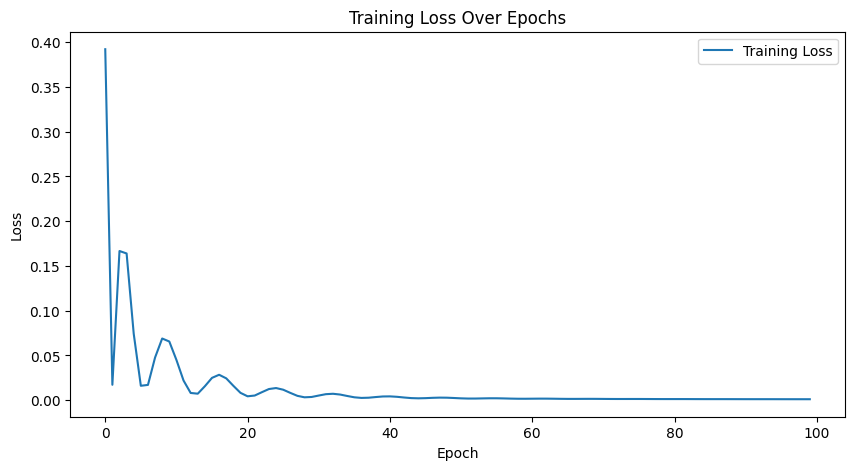

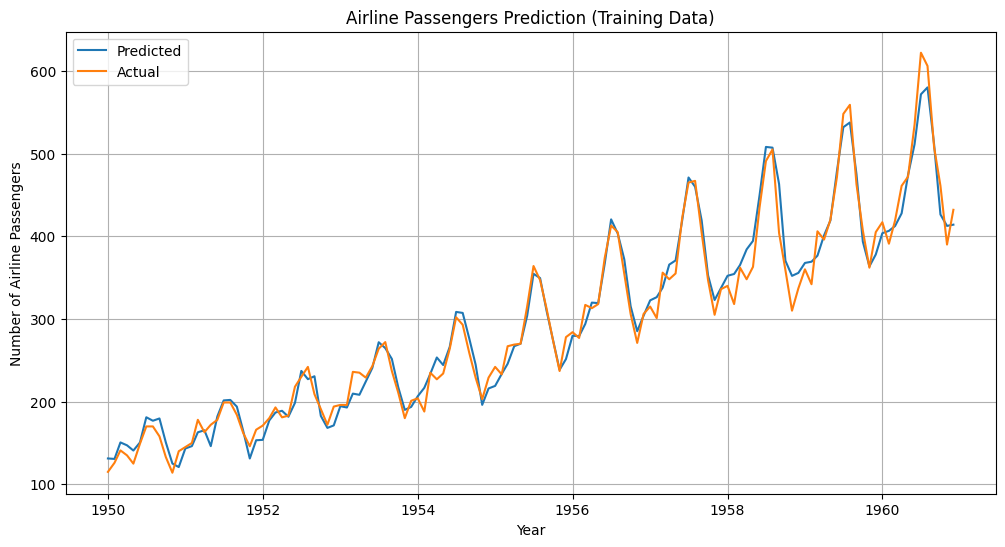

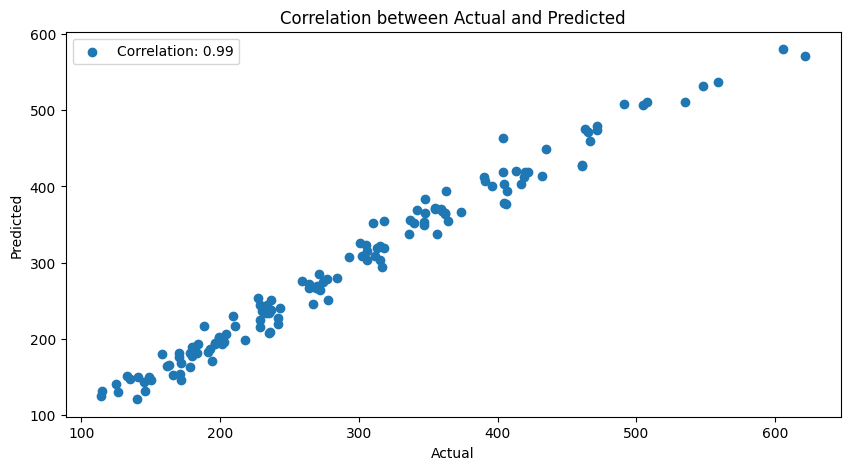

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

# Step 1: Load and Preprocess Data

# Load the Air Passengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

# Create sequences of data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12  # sequence length (number of time steps to look back)
x_train, y_train = create_sequences(scaled_data, seq_length)

# Step 2: Define an RNN Model
class ComplexRNN(tf.keras.Model):
    def __init__(self, hidden_size, num_layers, bidirectional=False, dropout=0.0):
        super(ComplexRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn = tf.keras.layers.RNN([
            tf.keras.layers.SimpleRNNCell(hidden_size) for _ in range(num_layers)
        ], return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(1)

    def call(self, x, states=None, training=False):
        x, *states = self.rnn(x, initial_state=states, training=training)
        out = self.fc(x[:, -1, :])
        return out, states

# Step 3: Training and Evaluation

# Hyperparameters
input_size = 1  # number of features (in this case, it's just the number of passengers)
hidden_size = 64
output_size = 1
num_layers = 2
bidirectional = False
dropout = 0.2
learning_rate = 0.001
num_epochs = 100
l2_lambda = 0.001  # L2 regularization parameter
patience = 10  # Early stopping patience

# Initialize the model
model = ComplexRNN(hidden_size, num_layers, bidirectional=bidirectional, dropout=dropout)
model.build((None, seq_length, input_size))
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

# Early stopping variables
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

losses = []
for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping")
        break

    with tf.GradientTape() as tape:
        outputs, states = model(x_train, training=True)
        loss = loss_fn(y_train, outputs) + l2_lambda * sum(model.losses)
        losses.append(loss.numpy())

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Early stopping logic
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.numpy():.4f}')

# Calculate Mean Absolute Error (MAE) after training
predicted = model(x_train, training=False)[0].numpy()
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
mae = mean_absolute_error(y_train_orig, predicted)
print(f'Mean Absolute Error (MAE) on training data: {mae:.2f}')

# Step 4: Test on New Data

# Generate new data for testing (out-of-sample)
new_data = scaled_data[-seq_length:]  # take the last sequence as new data
x_test = np.array(new_data.reshape(1, seq_length, -1), dtype=np.float32)

# Make predictions on the new data
predicted_new = model(x_test, training=False)[0].numpy()
predicted_new = scaler.inverse_transform(predicted_new.reshape(-1, 1))
print(f'Predicted number of passengers for next month: {predicted_new[0][0]:.2f}')

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[seq_length:], predicted, label='Predicted')
plt.plot(df.index[seq_length:], y_train_orig, label='Actual')
plt.xlabel('Year')
plt.ylabel('Number of Airline Passengers')
plt.title('Airline Passengers Prediction (Training Data)')
plt.legend()
plt.grid(True)
plt.show()

# Plot correlation
correlation, _ = pearsonr(y_train_orig.flatten(), predicted.flatten())
plt.figure(figsize=(10, 5))
plt.scatter(y_train_orig, predicted, label=f'Correlation: {correlation:.2f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Correlation between Actual and Predicted')
plt.legend()
plt.show()